# Analyzing Customer Satisfaction and Delivery Times by Category and Region

In [60]:
import pandas as pd 
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

## Kruskal-Wallis H Test

Used to compare the medians of 3 or more groups and identify if at least one differs significantly. It is similar to ANOVA, but used when the assumptions for ANOVA are violated (normality and Homoscedasticity).

We perform a Kruskal test for the average delivery times by category, and then by region, to investigate whether there are product categories and states with unusually high or low delivery times.

In [6]:
# import data
data = pd.read_csv('/Users/owenxuli/Documents/GitHub/olist-ecommerce-analysis/data/olist_complete.csv')

In [63]:
# select only relevant columns
data_category = data[['order_id', 'product_category', 'delivery_days']]

In [64]:
data_category.head()

,order_id,product_category,delivery_days
0,5f79b5b0931d63f1a42989eb65b9da6e,Entertainment,14
1,a44895d095d7e0702b6a162fa2dbeced,Health and Beauty,9
2,316a104623542e4d75189bb372bc5f8d,Fashion,6
3,5825ce2e88d5346438686b0bba99e5ee,Fashion,28
4,0ab7fb08086d4af9141453c91878ed7a,Furniture,11


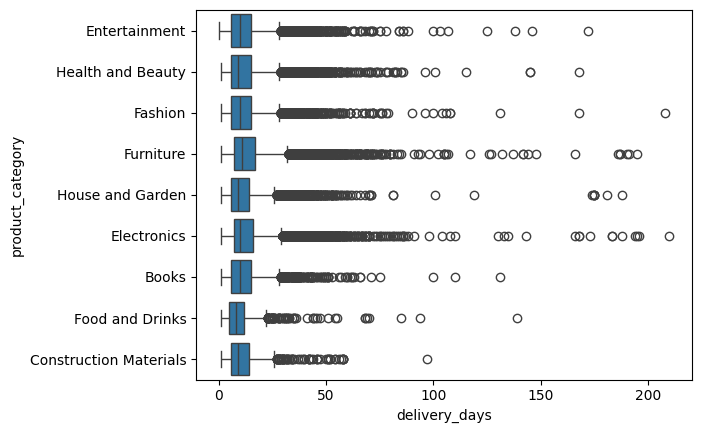

In [65]:
sns.boxplot(x='delivery_days', y = 'product_category', data=data_category)
plt.show()

Overall, the delivery days for each group seem to have the same shape and spread.

In [53]:
# group data
grouped_data_category = [group['delivery_days'].dropna() for name, group in data_category.groupby('product_category')]

In [54]:
len(grouped_data_category)

9

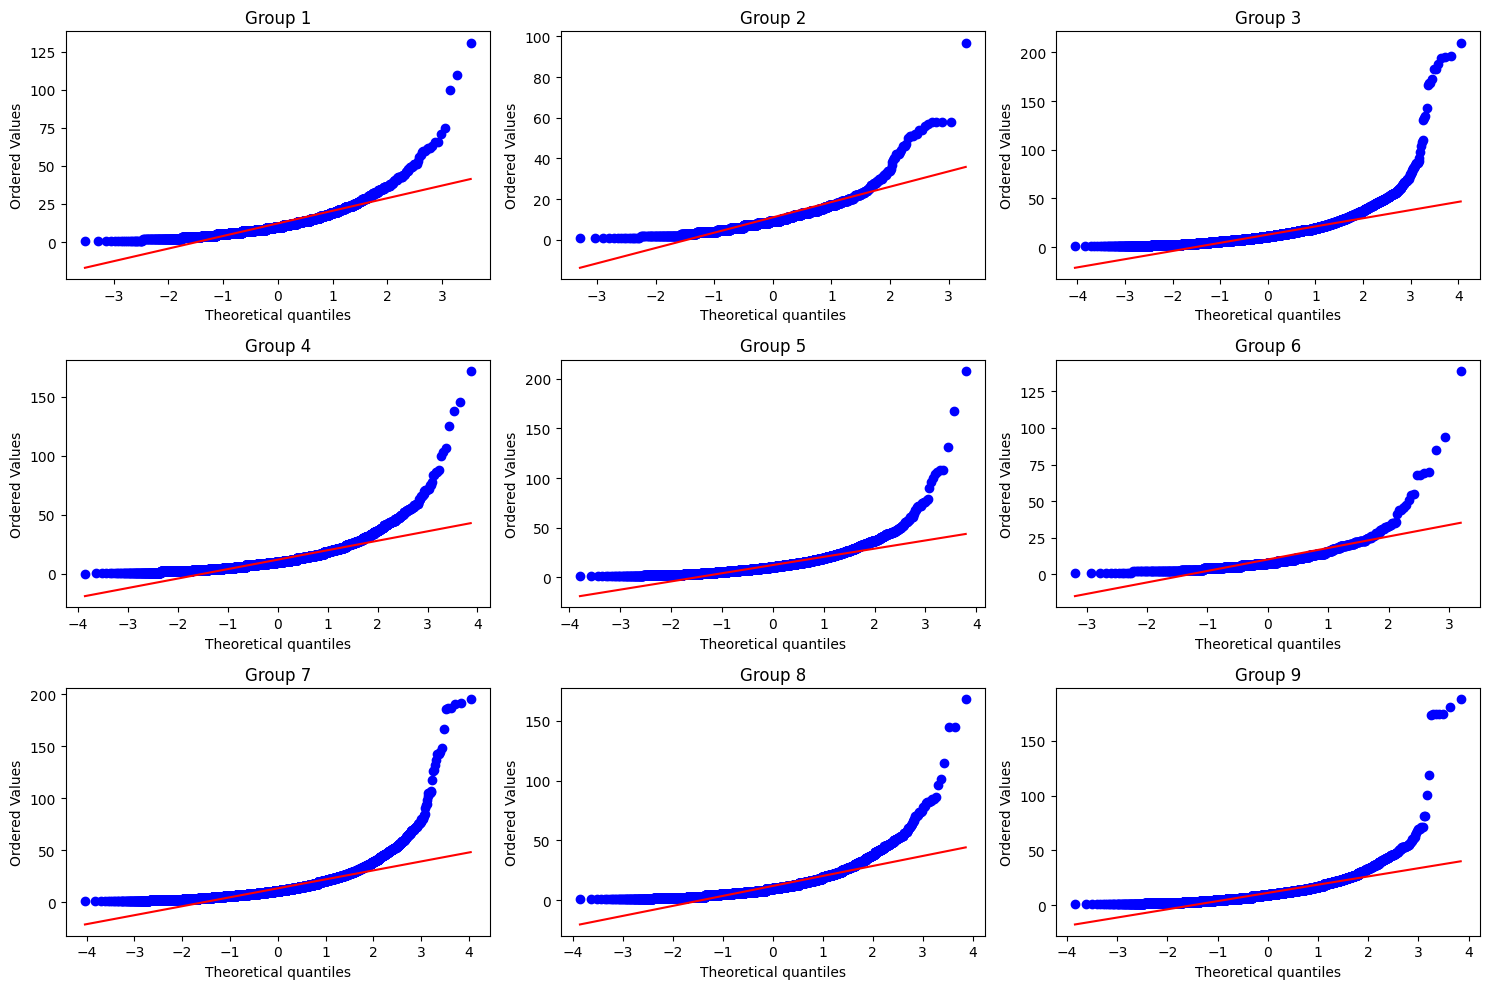

In [55]:
#1: Normality within groups
n_groups = len(grouped_data_category)
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

axes = axes.flatten()

for i, group in enumerate(grouped_data_category):
    if i < len(axes):
        scipy.stats.probplot(group, dist='norm', plot=axes[i])
        axes[i].set_title(f'Group {i + 1}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Since the tails diverge a lot from the line, the delivery days within each category do not seem to be normally distributed.

Now, we test for homogeneity (constant variance) within groups.

In [56]:
# we perform Levene's test because it's more robust to deviations from the normal distribution.

stat, pval = scipy.stats.levene(*grouped_data_category)

print(f"Levene's p-value: {pval}")

if pval > 0.05:
    print("Variances are equal across groups.")
else:
    print("Variances are not equal across groups.")

Levene's p-value: 8.350331700360118e-23
Variances are not equal across groups.


In [57]:
# perform kruskal test
f_statistic, p_value = scipy.stats.kruskal(*grouped_data_category)

In [58]:
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 1120.5349830592218
P-value: 1.4069627370798697e-236


In [70]:
# Interpretation
if p_value < 0.05:
    print('There is a significant difference in median delivery times between categories.')
else:
    print('Thre is no significance difference between median delivery times between categories.')

There is a significant difference in median delivery times between categories.


Since there is a significant difference in median delivery times, we now perform a post-hoc test to identify which categories differ the most.

In [69]:
for name, group in data_category.groupby('product_category'):
    print(name)

Books
Construction Materials
Electronics
Entertainment
Fashion
Food and Drinks
Furniture
Health and Beauty
House and Garden


In [67]:
import scikit_posthocs as sp

# Perform Dunn's test with Bonferroni correction for multiple comparisons
posthoc = sp.posthoc_dunn(grouped_data_category, p_adjust='bonferroni')

print(posthoc)

              1             2             3             4             5  \
1  1.000000e+00  1.242031e-05  1.121974e-03  1.000000e+00  1.000000e+00   
2  1.242031e-05  1.000000e+00  7.040340e-17  9.981719e-05  2.514392e-07   
3  1.121974e-03  7.040340e-17  1.000000e+00  4.194907e-22  2.228320e-08   
4  1.000000e+00  9.981719e-05  4.194907e-22  1.000000e+00  4.688678e-01   
5  1.000000e+00  2.514392e-07  2.228320e-08  4.688678e-01  1.000000e+00   
6  4.189634e-21  1.282497e-04  2.930063e-39  2.809527e-21  2.629834e-25   
7  1.748854e-17  1.758207e-31  6.973537e-23  2.787713e-71  9.146531e-40   
8  5.352530e-02  1.334266e-02  1.172353e-36  4.385386e-01  5.887029e-05   
9  1.010601e-06  1.000000e+00  2.434596e-62  2.746650e-08  1.457575e-14   

              6              7             8              9  
1  4.189634e-21   1.748854e-17  5.352530e-02   1.010601e-06  
2  1.282497e-04   1.758207e-31  1.334266e-02   1.000000e+00  
3  2.930063e-39   6.973537e-23  1.172353e-36   2.434596e-62  
4

It seems that the median delivery time for House and Garden, and Furniture products differ the most.

# Mutual Information Test

Now we investigate the correlation between delivery times and order reviews.

Mutual Information measures the amount of information obtained about one variable through the other. It quantifies the dependency between two variables and can capture both linear and non-linear relationships.

We don't use Pearson Correlation because our data is neither linearly related, nor normally distributed.

In [83]:
from sklearn.feature_selection import mutual_info_regression

In [90]:
data_mi = data.dropna(subset=['delivery_days', 'review_score'])

# we first select the columns
x = np.array(data_mi['delivery_days'])
y = np.array(data_mi['review_score'])

In [91]:
x.shape

(102561,)

In [92]:
y.shape

(102561,)

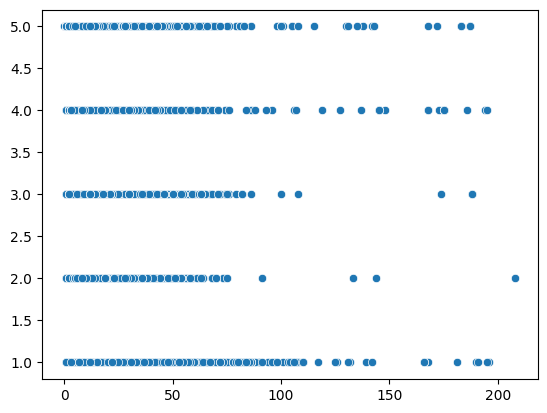

In [93]:
sns.scatterplot(x=x, y=y)
plt.show()

Just from the plot, there doesn't seem to be any strong relationship between delivery days and reviews.

In [94]:
# Compute Mutual Information
mi = mutual_info_regression(x.reshape(-1, 1), y)
print(f'Mutual Information: {mi[0]}')

Mutual Information: 0.05483253560991752


Unlike other statistical tests, there is no threshold for the Mutual Information regression. A higher value simply means you gain more information about y from x.

In this case, the mutual information score is quite low, at 0.05. Thus, we gain little information about the review scores based on the delivery days.

On the other hand, we can test for variables that we suspect are closely related, such as freight values (shipping costs) and sales value, since the customer often covers the shipping cost, so higher sales value would also indicate higher shipping.

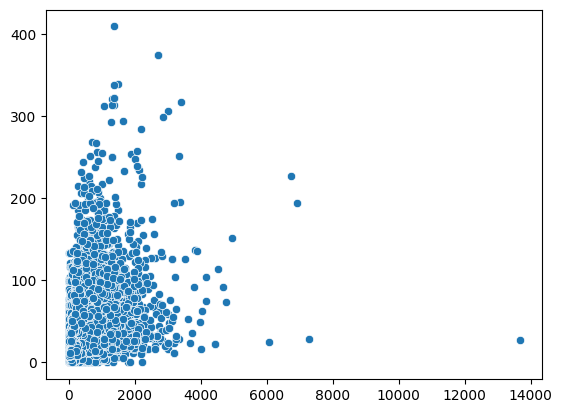

In [96]:
x = np.array(data_mi['sales_value'])
y = np.array(data_mi['freight_value'])

sns.scatterplot(x=x, y=y)
plt.show()

In [97]:
# Compute Mutual Information
mi = mutual_info_regression(x.reshape(-1, 1), y)
print(f'Mutual Information: {mi[0]}')

Mutual Information: 2.97453263008539


As expected, we gain much more information about the shipping cost from the sales value of an order.